# Lung cancer overall stage prediction

In [1]:
import radiomics as rm
import numpy as np
import nrrd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

lung_df = pd.read_csv('features.csv', sep=';')
target_df = pd.read_csv('NSCLC_target.csv')
lung_df = lung_df.join(target_df)

## Dataset exploration

In [2]:
lung_df.head()

,Unnamed: 0,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,...,PatientID,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Overall.Stage,Histology,gender,Survival.time,deadstatus.event
0,0,0.730057,0.547390,46.111107,84.238088,94.916393,82.904318,95.048181,95.453350,156058.192253,...,LUNG1-001,78.7515,2.0,3,0,IIIb,large cell,male,2165,1
1,1,0.880026,0.755086,70.050510,92.771551,116.811054,101.661967,103.566608,125.188825,359165.698933,...,LUNG1-002,83.8001,2.0,0,0,I,squamous cell carcinoma,male,155,1
2,2,0.541368,0.349893,25.216240,72.068431,56.708364,83.506157,62.535632,83.967822,34629.834720,...,LUNG1-003,68.1807,2.0,3,0,IIIb,large cell,male,256,1
3,3,0.490820,0.287317,30.821869,107.274834,110.729228,110.003931,68.533539,117.543366,84214.687347,...,LUNG1-004,70.8802,2.0,1,0,II,squamous cell carcinoma,male,141,1
4,4,0.710922,0.448589,35.245066,78.568642,77.737209,87.455405,85.094400,103.629893,83150.790783,...,LUNG1-005,80.4819,4.0,2,0,IIIb,squamous cell carcinoma,male,353,1


In [3]:
lung_df = lung_df.drop(['Unnamed: 0'], axis=1)

In [4]:
lung_df.shape

(422, 111)

In [5]:
lung_df.describe()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,metastases,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Survival.time,deadstatus.event
count,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,...,422.000000,422.000000,422.000000,422.000000,400.000000,421.000000,422.000000,422.000000,422.000000,422.000000
mean,0.728937,0.564163,31.579197,59.903315,61.618195,62.590186,58.770415,72.425552,72194.981000,41.240452,...,0.242888,208.398794,0.001459,0.736967,68.036500,2.475059,1.355450,0.030806,988.857820,0.883886
std,0.159549,0.155409,15.240503,33.986929,31.548944,31.419757,28.662955,35.414637,93959.171485,19.420478,...,0.125994,80.947686,0.002055,0.863352,10.083498,1.130727,1.218116,0.294847,1035.567789,0.320742
min,0.062267,0.000000,0.000000,11.611576,11.301772,11.920146,12.079411,13.423194,472.784042,8.838781,...,0.033809,23.588675,0.000032,0.000000,33.684900,1.000000,0.000000,0.000000,10.000000,0.000000
25%,0.644885,0.471294,19.506015,34.690059,36.133637,36.631579,35.434087,42.904660,10188.102722,25.453748,...,0.148155,152.424461,0.000350,0.000000,61.234800,2.000000,0.000000,0.000000,261.000000,1.000000
50%,0.752510,0.575873,30.138991,54.390975,57.376514,57.874786,57.083719,68.111635,38690.883444,39.458662,...,0.213871,202.235113,0.000689,1.000000,68.583400,2.000000,2.000000,0.000000,545.500000,1.000000
75%,0.847179,0.668792,41.625214,75.877961,81.687375,82.227255,78.165686,95.151588,101446.032524,54.905546,...,0.326049,262.841738,0.001615,1.000000,75.814475,4.000000,2.000000,0.000000,1397.000000,1.000000
max,0.997176,0.915317,85.556390,304.261528,216.793900,187.719847,208.353677,216.848881,661001.068732,95.426431,...,0.634076,503.115123,0.014100,6.000000,91.704300,5.000000,4.000000,3.000000,4454.000000,1.000000


C:\Users\amosc\anaconda3\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


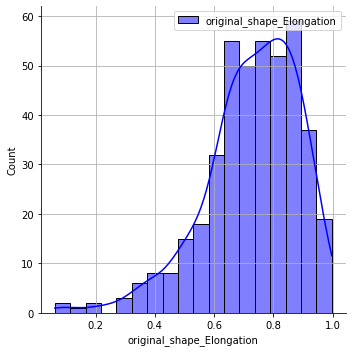

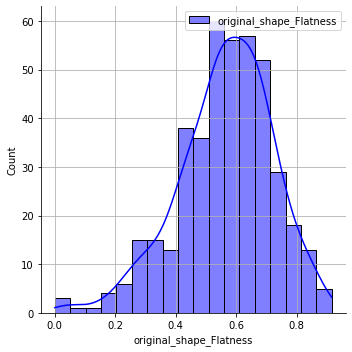

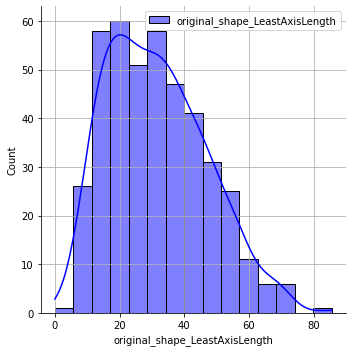

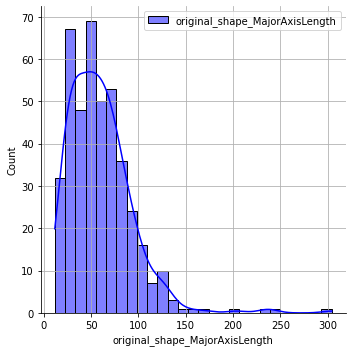

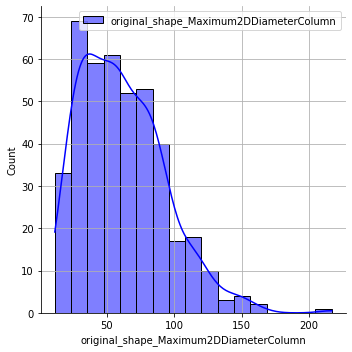

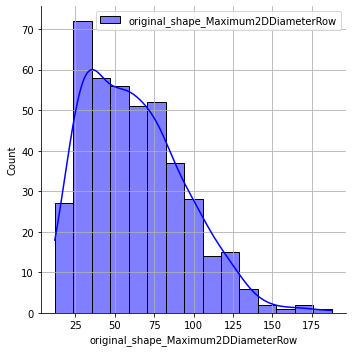

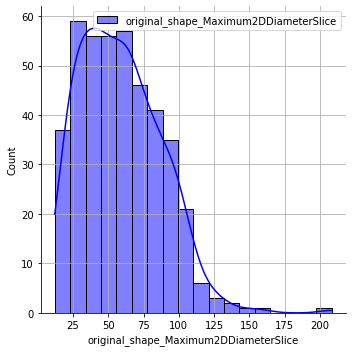

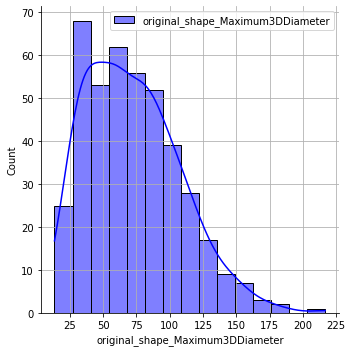

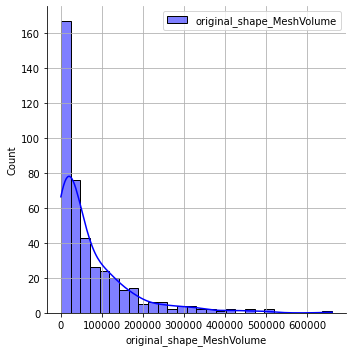

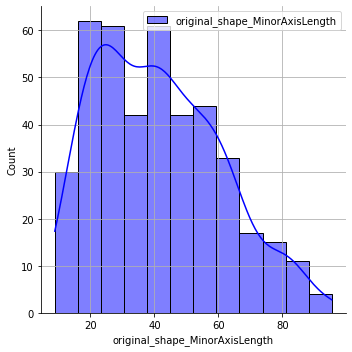

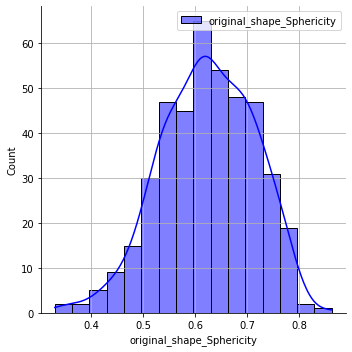

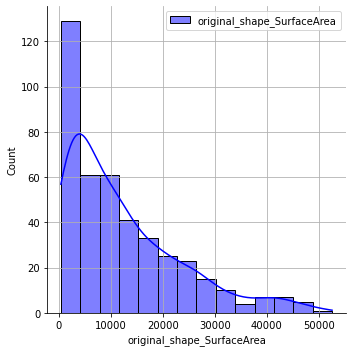

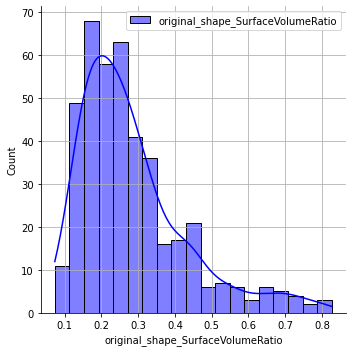

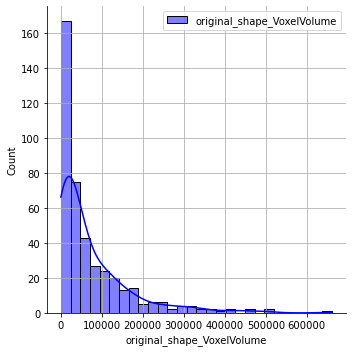

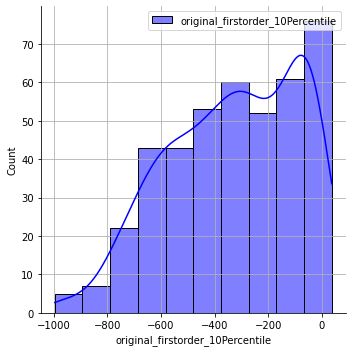

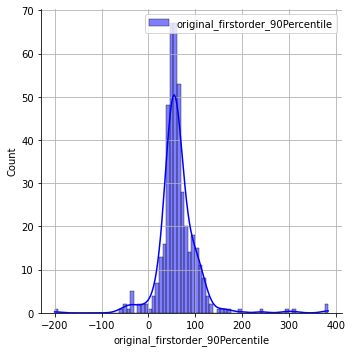

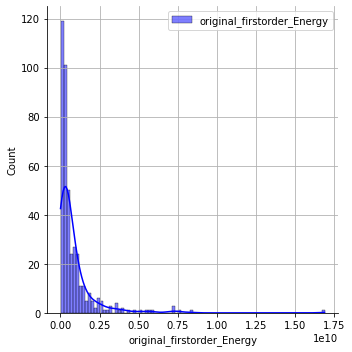

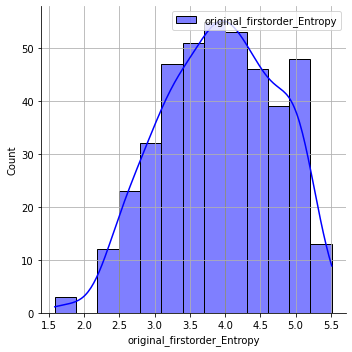

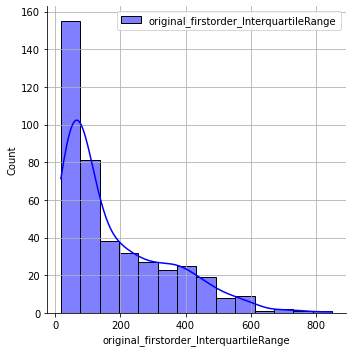

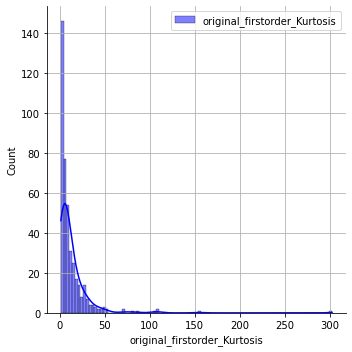

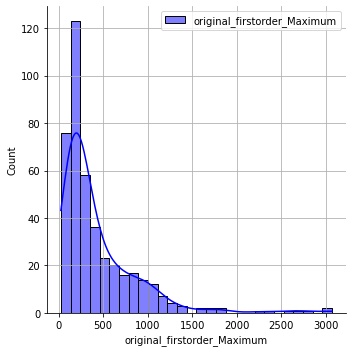

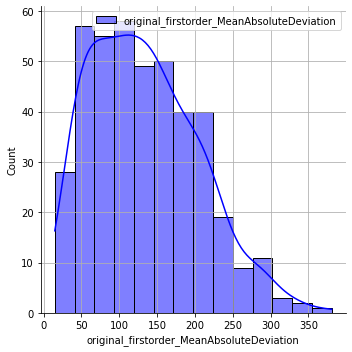

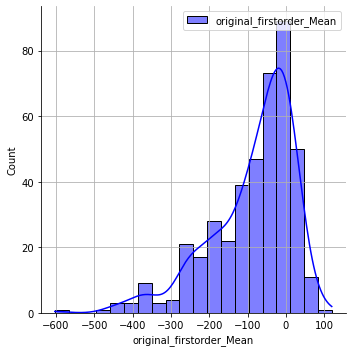

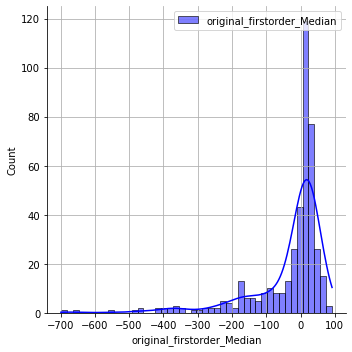

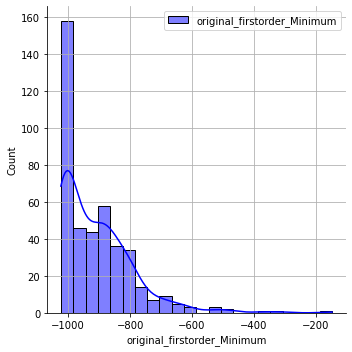

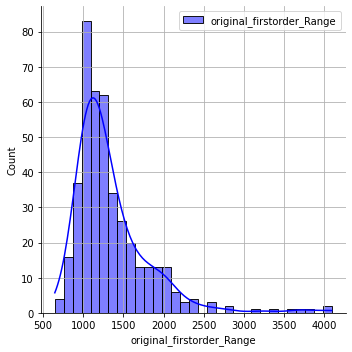

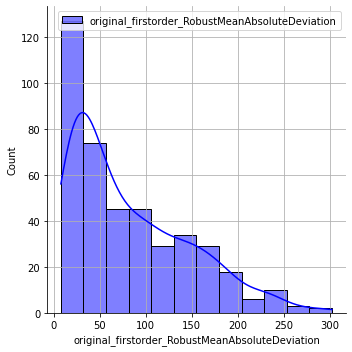

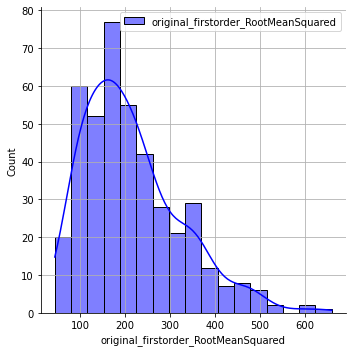

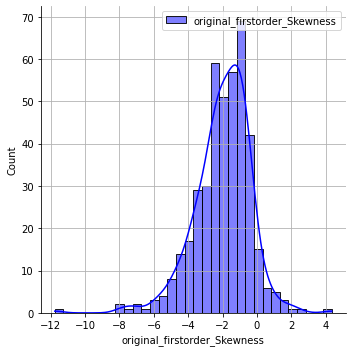

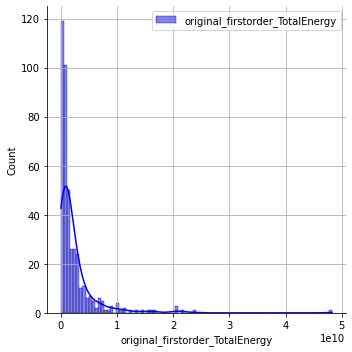

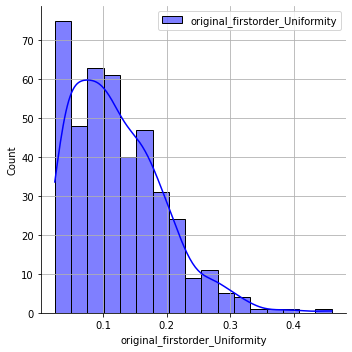

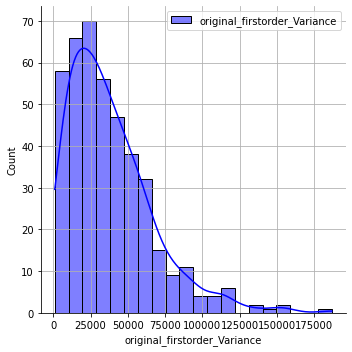

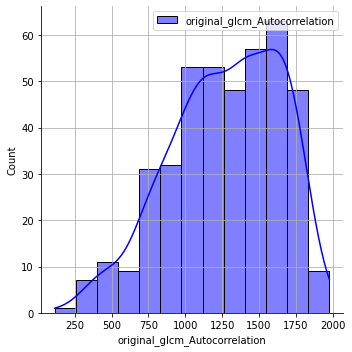

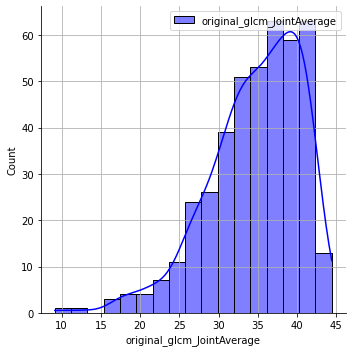

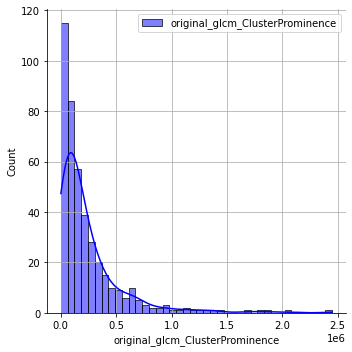

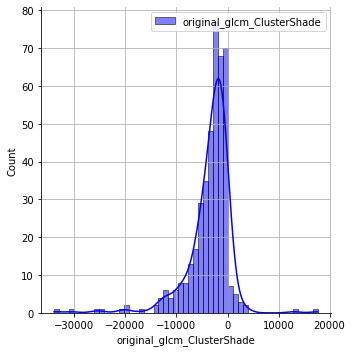

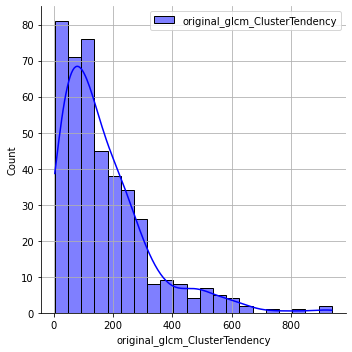

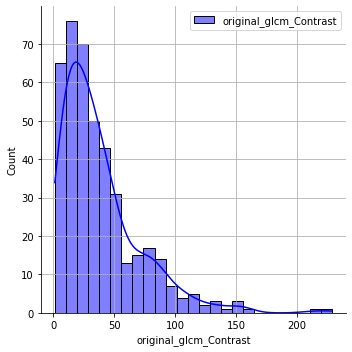

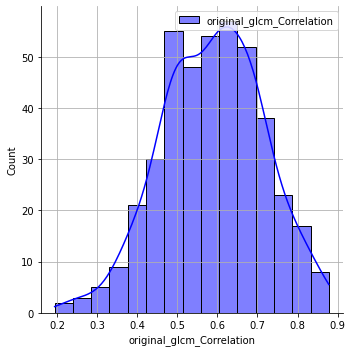

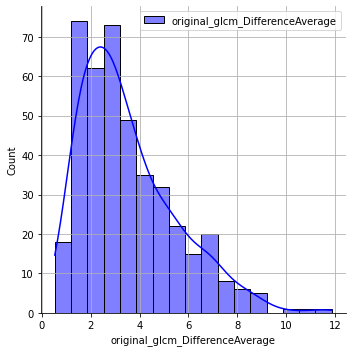

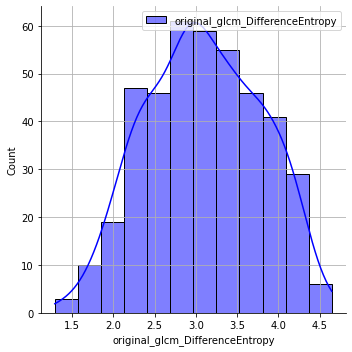

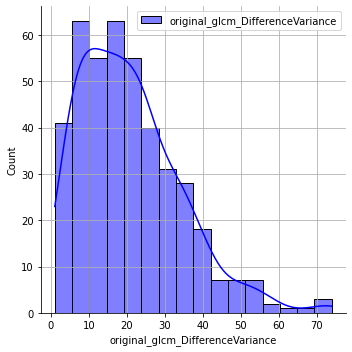

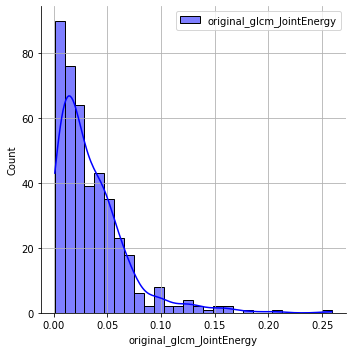

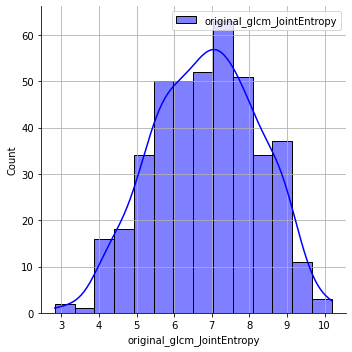

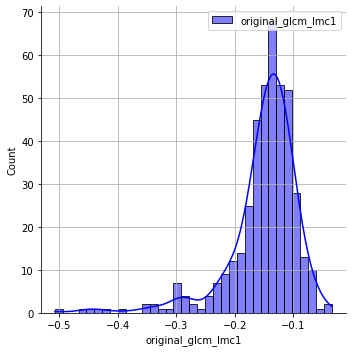

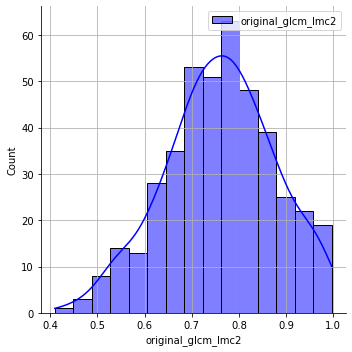

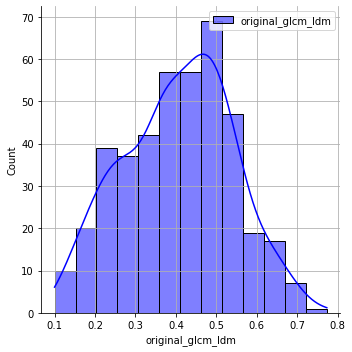

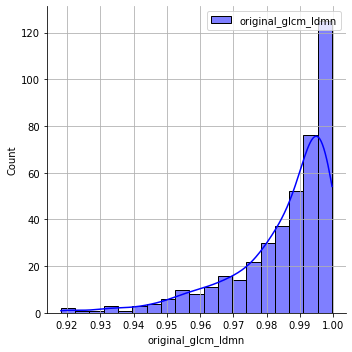

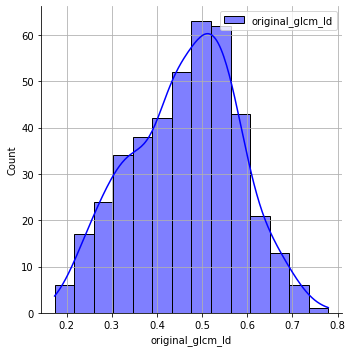

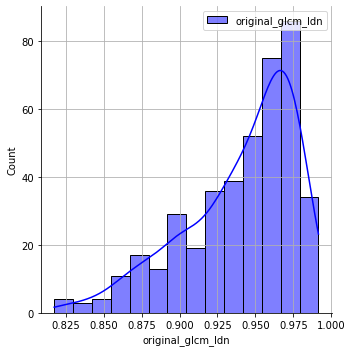

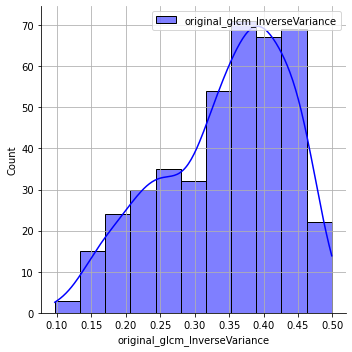

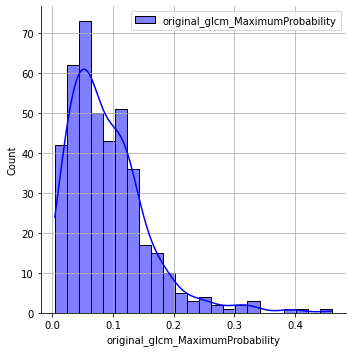

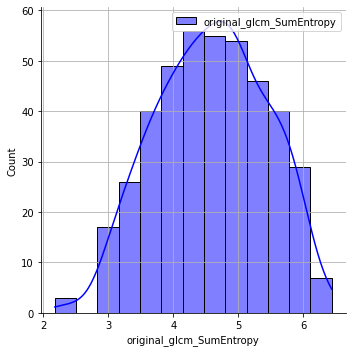

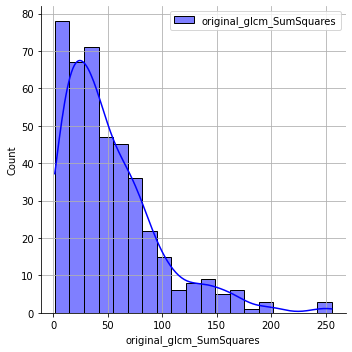

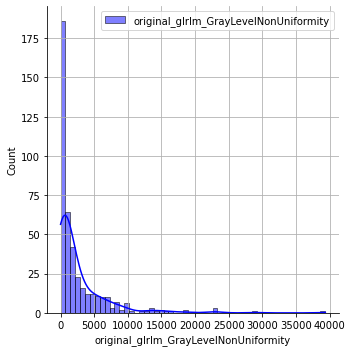

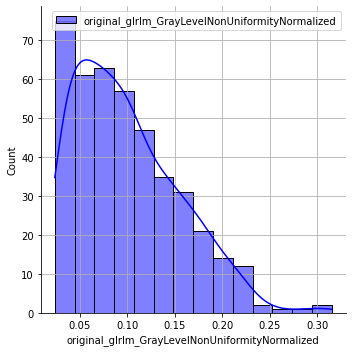

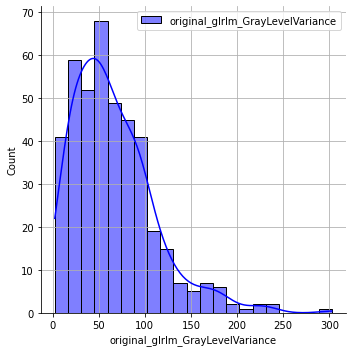

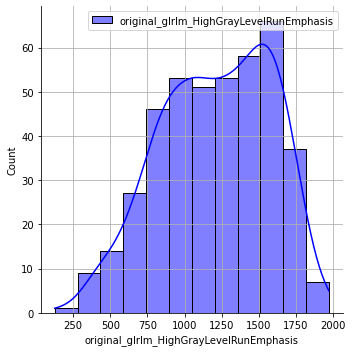

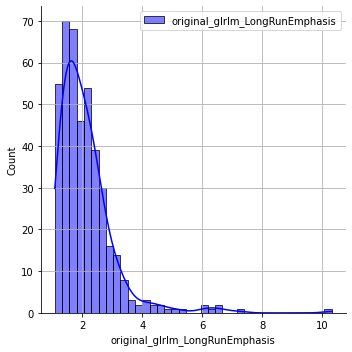

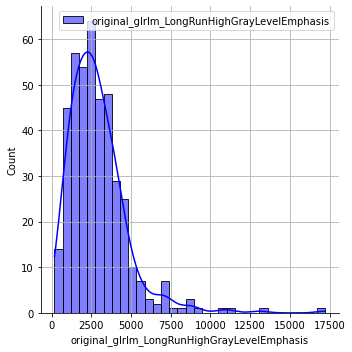

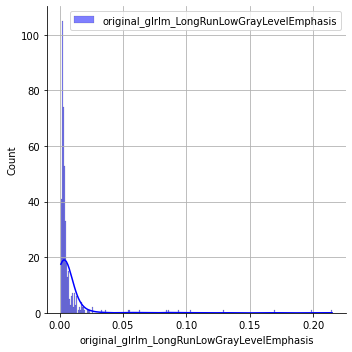

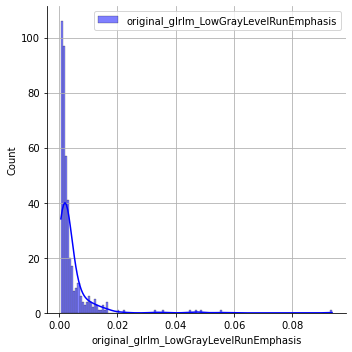

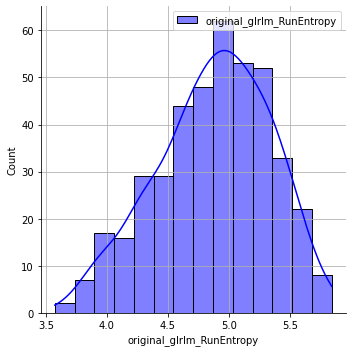

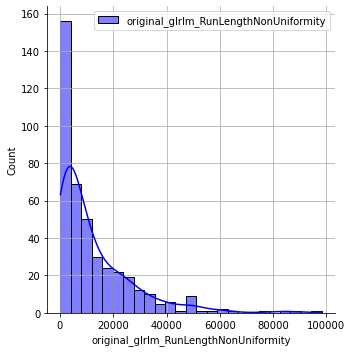

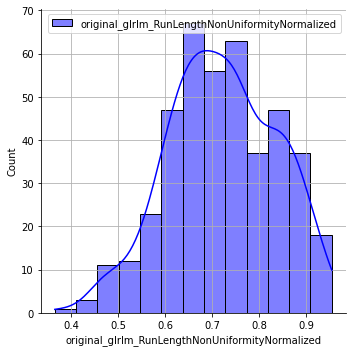

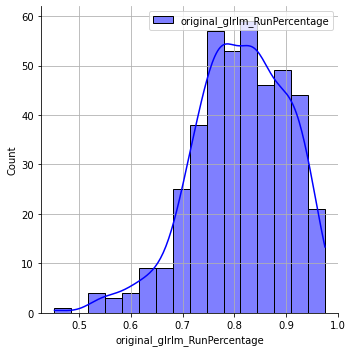

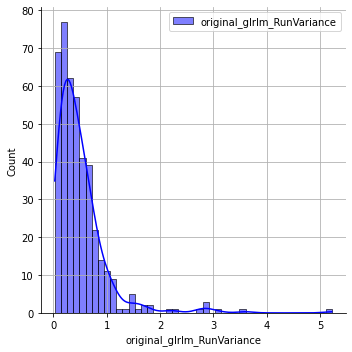

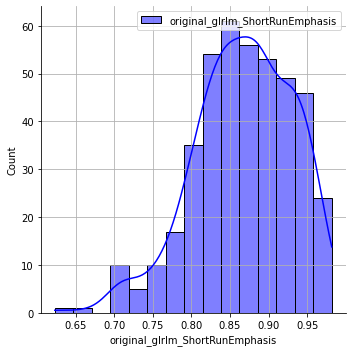

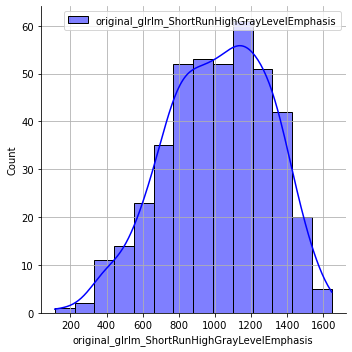

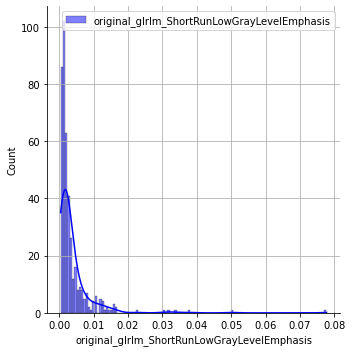

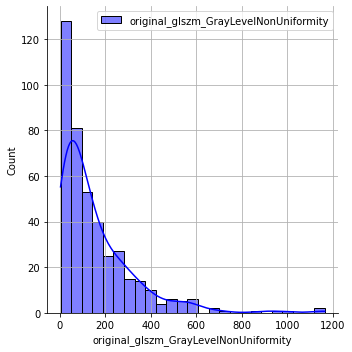

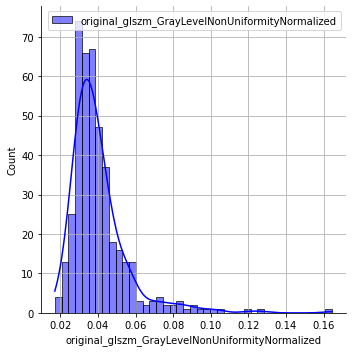

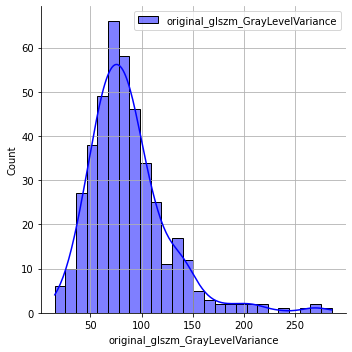

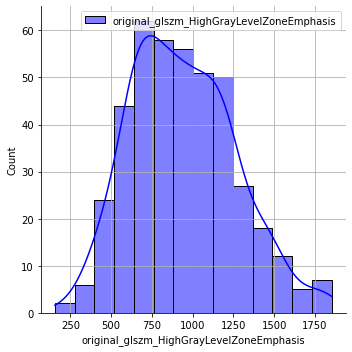

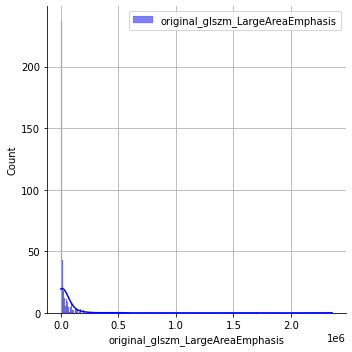

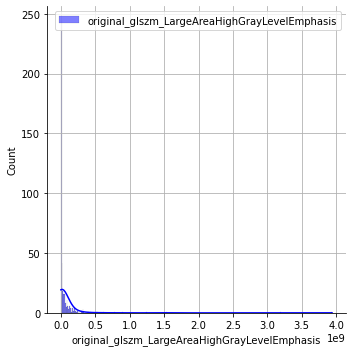

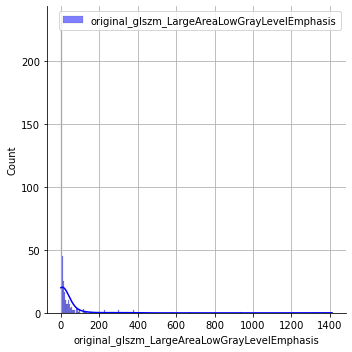

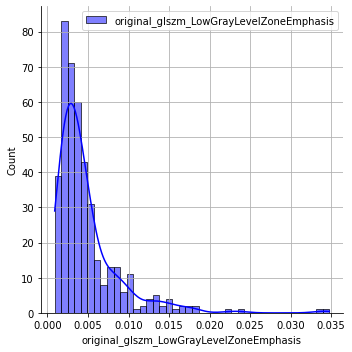

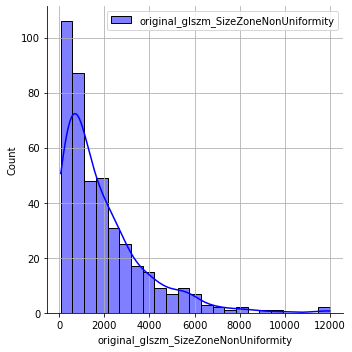

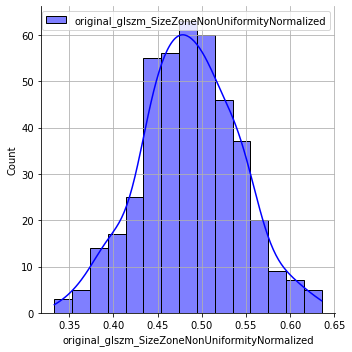

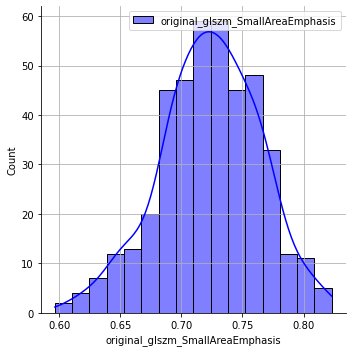

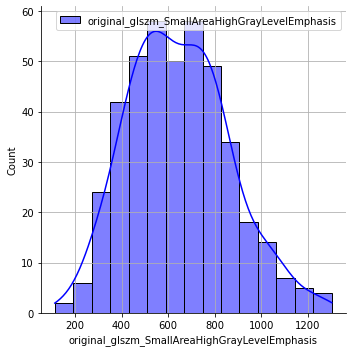

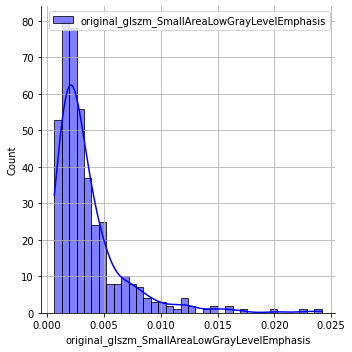

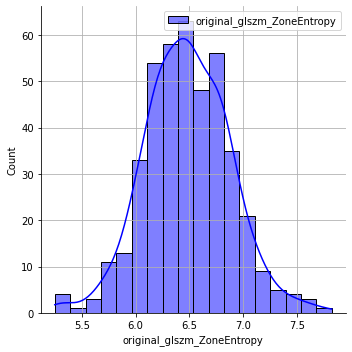

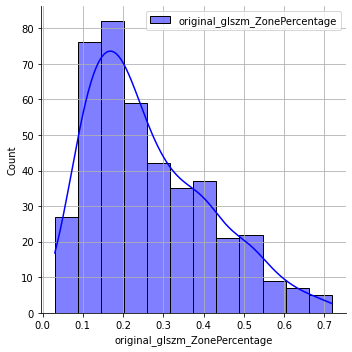

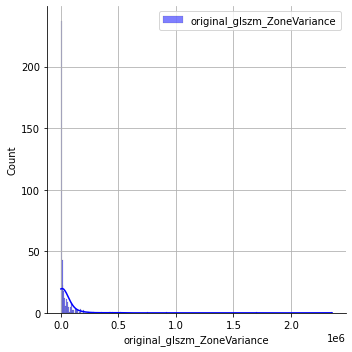

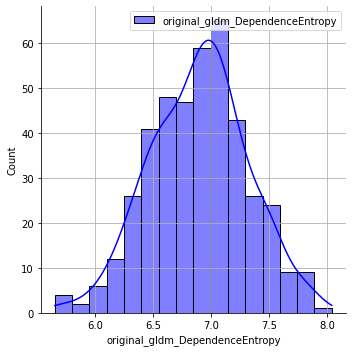

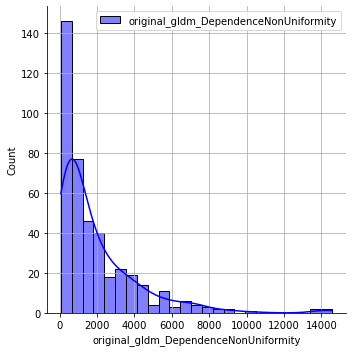

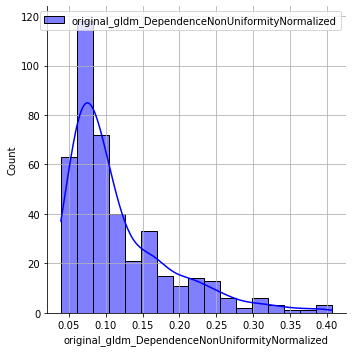

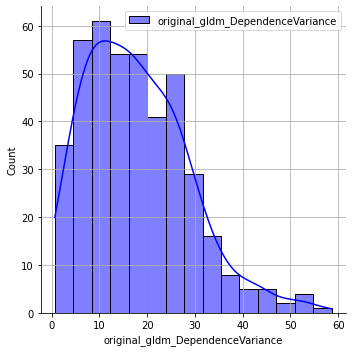

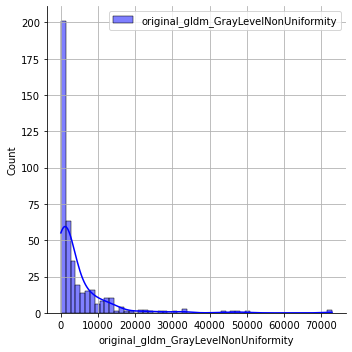

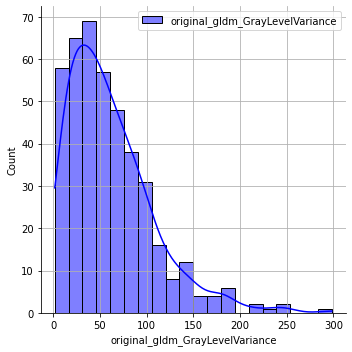

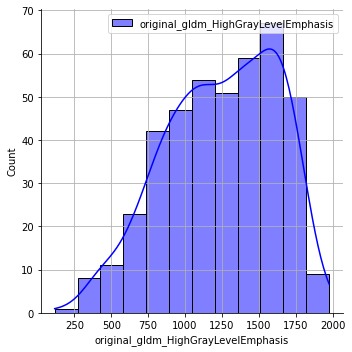

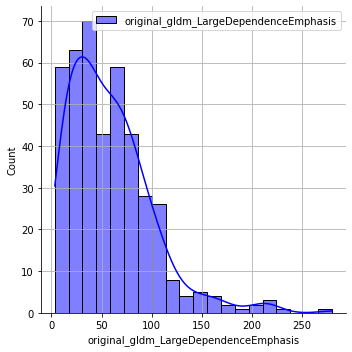

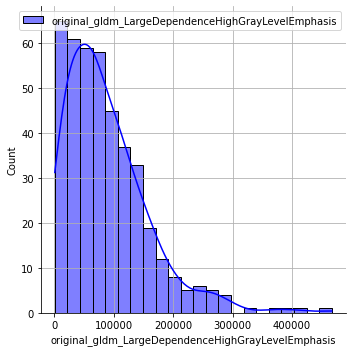

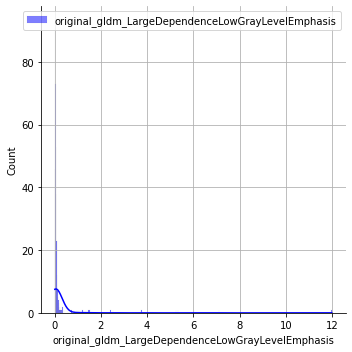

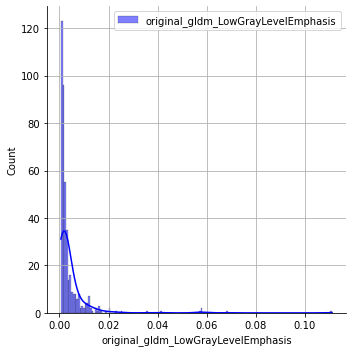

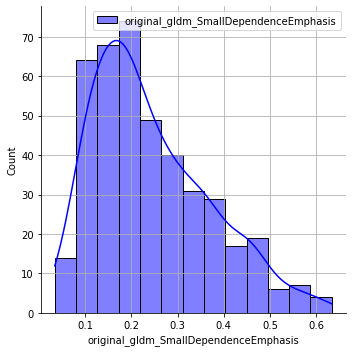

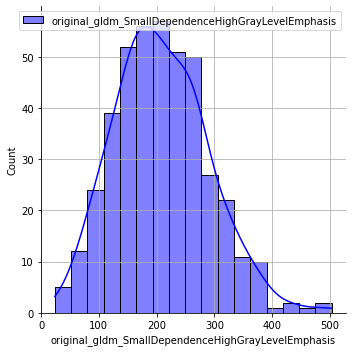

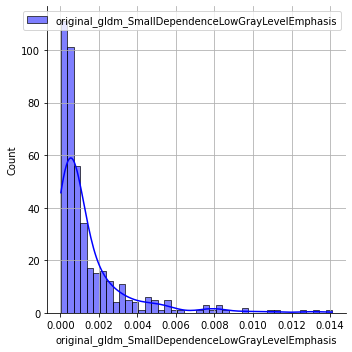

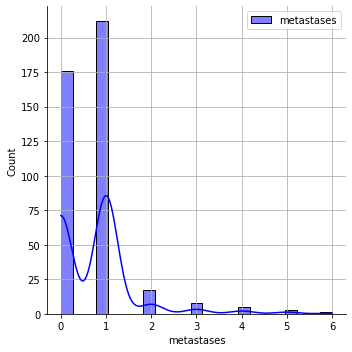

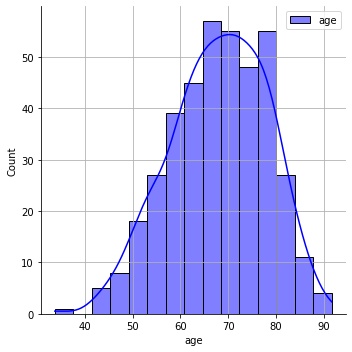

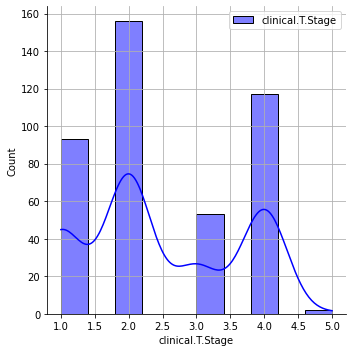

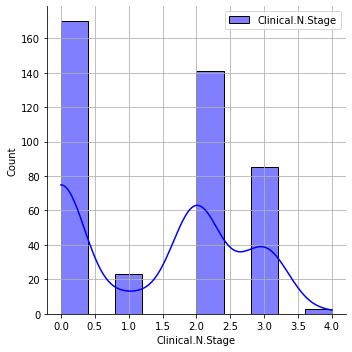

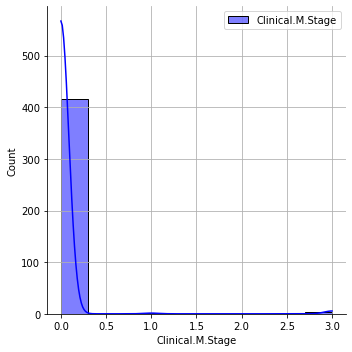

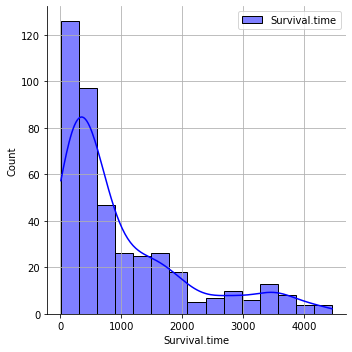

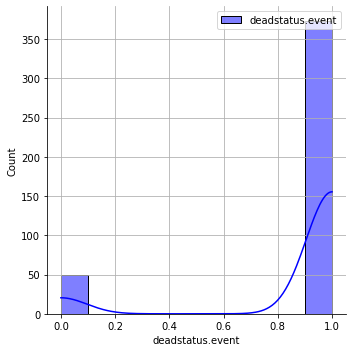

In [305]:
df_numerical = lung_df.select_dtypes(exclude=["object"])

for i, col in enumerate(list(df_numerical.columns)):
    sns.displot(lung_df[col], color = 'b', kde= True, label = lung_df[col].name)
    plt.grid()
    plt.legend(loc="upper right")
    plt.tight_layout()

In [11]:
clean_lung = lung_df.drop(["gender", "age", "PatientID"], axis=1)
clean_lung = clean_lung.rename(columns={"clinical.T.Stage": "t_stage", "Clinical.N.Stage": "n_stage", 
                                        "Clinical.M.Stage": "m_stage"})

t_stage = clean_lung["t_stage"]
n_stage = clean_lung["n_stage"]
m_stage = clean_lung["m_stage"]

## Feature processing

In [13]:
from sklearn.preprocessing import LabelEncoder

predict_overall_stage = clean_lung.drop(["Histology", "Survival.time", "deadstatus.event", "m_stage", "n_stage", "t_stage"]
                                        , axis=1)
predict_overall_stage = predict_overall_stage.drop(labels=271, axis=0)

predict_overall_stage['Overall.Stage'].dropna(inplace = True)
predict_overall_stage = predict_overall_stage.rename(columns={"Overall.Stage": "overall_stage"})
target_overall = predict_overall_stage['overall_stage']

    
label_encoder = LabelEncoder()
target_overall = label_encoder.fit_transform(target_overall)
target_overall

array([3, 0, 3, 1, 3, 2, 2, 2, 2, 3, 3, 2, 0, 3, 0, 0, 3, 1, 0, 3, 3, 0,
       2, 0, 3, 3, 0, 0, 2, 3, 2, 0, 3, 3, 2, 2, 2, 3, 0, 2, 0, 3, 3, 3,
       1, 0, 2, 3, 0, 2, 0, 2, 1, 3, 3, 2, 2, 0, 2, 0, 3, 3, 1, 1, 3, 3,
       2, 3, 3, 0, 3, 3, 3, 3, 3, 2, 1, 0, 2, 0, 3, 3, 0, 2, 3, 3, 0, 3,
       3, 0, 2, 3, 2, 0, 0, 3, 0, 0, 1, 0, 3, 0, 2, 1, 1, 3, 3, 3, 1, 2,
       0, 0, 2, 2, 2, 3, 3, 0, 3, 3, 2, 0, 3, 3, 3, 3, 3, 2, 3, 3, 0, 3,
       0, 0, 3, 0, 3, 0, 3, 3, 1, 2, 3, 3, 0, 2, 2, 2, 3, 0, 1, 0, 0, 0,
       3, 3, 0, 2, 0, 0, 0, 3, 2, 2, 2, 1, 3, 3, 3, 3, 0, 2, 1, 0, 0, 0,
       2, 3, 3, 2, 2, 3, 2, 0, 1, 3, 0, 2, 3, 0, 3, 3, 2, 3, 2, 2, 3, 3,
       2, 1, 0, 2, 0, 0, 3, 2, 0, 2, 2, 0, 3, 0, 2, 3, 3, 3, 3, 3, 2, 2,
       3, 3, 0, 2, 0, 3, 2, 2, 3, 1, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3,
       2, 3, 3, 3, 2, 3, 3, 2, 3, 0, 0, 2, 0, 3, 2, 3, 3, 0, 3, 3, 1, 3,
       2, 2, 3, 3, 2, 2, 2, 1, 2, 3, 2, 3, 1, 3, 3, 1, 3, 3, 3, 2, 2, 3,
       3, 3, 3, 2, 3, 0, 2, 2, 2, 3, 0, 3, 3, 2, 3,

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

features_overall = predict_overall_stage.drop(["overall_stage"], axis=1)
features_overall = features_overall.fillna(0)
features_overall

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,metastases
0,0.730057,0.547390,46.111107,84.238088,94.916393,82.904318,95.048181,95.453350,156058.192253,61.498644,...,65.890341,1583.334962,64.282088,114939.612603,0.102407,0.002637,0.186916,206.427211,0.000523,0.0
1,0.880026,0.755086,70.050510,92.771551,116.811054,101.661967,103.566608,125.188825,359165.698933,81.641365,...,88.444688,1651.377715,76.437748,142846.540839,0.052014,0.001332,0.142663,165.984345,0.000334,0.0
2,0.541368,0.349893,25.216240,72.068431,56.708364,83.506157,62.535632,83.967822,34629.834720,39.015548,...,99.383954,1355.354470,25.568303,43154.784522,0.019421,0.001525,0.304123,311.508421,0.000710,2.0
3,0.490820,0.287317,30.821869,107.274834,110.729228,110.003931,68.533539,117.543366,84214.687347,52.652619,...,43.820066,1533.333966,40.228007,68201.600149,0.026679,0.001167,0.202153,253.308845,0.000398,2.0
4,0.710922,0.448589,35.245066,78.568642,77.737209,87.455405,85.094400,103.629893,83150.790783,55.856187,...,56.427838,1785.882712,43.938237,85015.211818,0.027079,0.001295,0.193209,277.260954,0.000468,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,0.956116,0.520980,40.251075,77.260243,101.965908,118.000536,145.900529,146.334346,94588.637352,73.869738,...,42.388159,1691.335476,101.637206,183819.319116,0.073470,0.001224,0.148707,207.179793,0.000237,1.0
418,0.642440,0.497774,43.610094,87.610311,69.745562,108.443940,96.343719,109.304718,132211.446762,56.284411,...,28.020261,1660.491514,107.774755,194589.231507,0.062325,0.000868,0.138558,167.362281,0.000204,1.0
419,0.873311,0.683309,24.342849,35.624951,43.319309,41.255789,41.946741,43.713782,18872.380257,31.111663,...,46.072588,1103.694754,88.975580,117774.434278,0.069912,0.001818,0.234923,169.101021,0.000843,1.0
420,0.775330,0.640303,33.136846,51.751822,58.755344,58.028557,63.925695,67.862169,42064.547539,40.124730,...,73.889902,1516.309896,95.202262,170635.632121,0.078652,0.002560,0.221144,222.123611,0.000645,1.0


## Feature scaling

In [16]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
scaler = RobustScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(features_overall))

In [17]:
from sklearn.model_selection import train_test_split

overall_X_train, overall_X_test, overall_y_train, overall_y_test = train_test_split(scaled_features, target_overall, 
                                                                                    test_size=0.2, random_state=0)

## Feature selection

In [18]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )
search.fit(overall_X_train, overall_y_train)

coefficients = search.best_estimator_.named_steps['model'].coef_

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV] model__alpha=0.1 ................................................
[CV] ................... model__alpha=0.1, score=-1.002, total=   0.0s
[CV] model__alpha=0.1 ................................................
[CV] ................... model__alpha=0.1, score=-0.981, total=   0.0s
[CV] model__alpha=0.1 ................................................
[CV] ................... model__alpha=0.1, score=-1.170, total=   0.0s
[CV] model__alpha=0.1 ................................................
[CV] ................... model__alpha=0.1, score=-1.131, total=   0.0s
[CV] model__alpha=0.1 ................................................
[CV] ................... model__alpha=0.1, score=-1.105, total=   0.0s
[CV] model__alpha=0.2 ................................................
[CV] ................... model__alpha=0.2, score=-1.053, total=   0.0s
[CV] model__alpha=0.2 ................................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .... model__alpha=0.7000000000000001, score=-1.245, total=   0.0s
[CV] model__alpha=0.7000000000000001 .................................
[CV] .... model__alpha=0.7000000000000001, score=-1.167, total=   0.0s
[CV] model__alpha=0.7000000000000001 .................................
[CV] .... model__alpha=0.7000000000000001, score=-1.472, total=   0.0s
[CV] model__alpha=0.7000000000000001 .................................
[CV] .... model__alpha=0.7000000000000001, score=-1.460, total=   0.0s
[CV] model__alpha=0.7000000000000001 .................................
[CV] .... model__alpha=0.7000000000000001, score=-1.443, total=   0.0s
[CV] model__alpha=0.8 ................................................
[CV] ................... model__alpha=0.8, score=-1.245, total=   0.0s
[CV] model__alpha=0.8 ................................................
[CV] ................... model__alpha=0.8, score=-1.167, total=   0.0s
[CV] model__alpha=0.8 ................................................
[CV] .

[CV] .... model__alpha=1.9000000000000001, score=-1.443, total=   0.0s
[CV] model__alpha=2.0 ................................................
[CV] ................... model__alpha=2.0, score=-1.245, total=   0.0s
[CV] model__alpha=2.0 ................................................
[CV] ................... model__alpha=2.0, score=-1.167, total=   0.0s
[CV] model__alpha=2.0 ................................................
[CV] ................... model__alpha=2.0, score=-1.472, total=   0.0s
[CV] model__alpha=2.0 ................................................
[CV] ................... model__alpha=2.0, score=-1.460, total=   0.0s
[CV] model__alpha=2.0 ................................................
[CV] ................... model__alpha=2.0, score=-1.443, total=   0.0s
[CV] model__alpha=2.1 ................................................
[CV] ................... model__alpha=2.1, score=-1.245, total=   0.0s
[CV] model__alpha=2.1 ................................................
[CV] .

[CV] ................... model__alpha=3.2, score=-1.472, total=   0.0s
[CV] model__alpha=3.2 ................................................
[CV] ................... model__alpha=3.2, score=-1.460, total=   0.0s
[CV] model__alpha=3.2 ................................................
[CV] ................... model__alpha=3.2, score=-1.443, total=   0.0s
[CV] model__alpha=3.3000000000000003 .................................
[CV] .... model__alpha=3.3000000000000003, score=-1.245, total=   0.0s
[CV] model__alpha=3.3000000000000003 .................................
[CV] .... model__alpha=3.3000000000000003, score=-1.167, total=   0.0s
[CV] model__alpha=3.3000000000000003 .................................
[CV] .... model__alpha=3.3000000000000003, score=-1.472, total=   0.0s
[CV] model__alpha=3.3000000000000003 .................................
[CV] .... model__alpha=3.3000000000000003, score=-1.460, total=   0.0s
[CV] model__alpha=3.3000000000000003 .................................
[CV] .

[CV] ................... model__alpha=4.5, score=-1.460, total=   0.0s
[CV] model__alpha=4.5 ................................................
[CV] ................... model__alpha=4.5, score=-1.443, total=   0.0s
[CV] model__alpha=4.6 ................................................
[CV] ................... model__alpha=4.6, score=-1.245, total=   0.0s
[CV] model__alpha=4.6 ................................................
[CV] ................... model__alpha=4.6, score=-1.167, total=   0.0s
[CV] model__alpha=4.6 ................................................
[CV] ................... model__alpha=4.6, score=-1.472, total=   0.0s
[CV] model__alpha=4.6 ................................................
[CV] ................... model__alpha=4.6, score=-1.460, total=   0.0s
[CV] model__alpha=4.6 ................................................
[CV] ................... model__alpha=4.6, score=-1.443, total=   0.0s
[CV] model__alpha=4.7 ................................................
[CV] .

[CV] ................... model__alpha=5.8, score=-1.472, total=   0.0s
[CV] model__alpha=5.8 ................................................
[CV] ................... model__alpha=5.8, score=-1.460, total=   0.0s
[CV] model__alpha=5.8 ................................................
[CV] ................... model__alpha=5.8, score=-1.443, total=   0.0s
[CV] model__alpha=5.9 ................................................
[CV] ................... model__alpha=5.9, score=-1.245, total=   0.0s
[CV] model__alpha=5.9 ................................................
[CV] ................... model__alpha=5.9, score=-1.167, total=   0.0s
[CV] model__alpha=5.9 ................................................
[CV] ................... model__alpha=5.9, score=-1.472, total=   0.0s
[CV] model__alpha=5.9 ................................................
[CV] ................... model__alpha=5.9, score=-1.460, total=   0.0s
[CV] model__alpha=5.9 ................................................
[CV] .

[CV] ................... model__alpha=7.1, score=-1.472, total=   0.0s
[CV] model__alpha=7.1 ................................................
[CV] ................... model__alpha=7.1, score=-1.460, total=   0.0s
[CV] model__alpha=7.1 ................................................
[CV] ................... model__alpha=7.1, score=-1.443, total=   0.0s
[CV] model__alpha=7.2 ................................................
[CV] ................... model__alpha=7.2, score=-1.245, total=   0.0s
[CV] model__alpha=7.2 ................................................
[CV] ................... model__alpha=7.2, score=-1.167, total=   0.0s
[CV] model__alpha=7.2 ................................................
[CV] ................... model__alpha=7.2, score=-1.472, total=   0.0s
[CV] model__alpha=7.2 ................................................
[CV] ................... model__alpha=7.2, score=-1.460, total=   0.0s
[CV] model__alpha=7.2 ................................................
[CV] .

[CV] ................... model__alpha=8.4, score=-1.460, total=   0.0s
[CV] model__alpha=8.4 ................................................
[CV] ................... model__alpha=8.4, score=-1.443, total=   0.0s
[CV] model__alpha=8.5 ................................................
[CV] ................... model__alpha=8.5, score=-1.245, total=   0.0s
[CV] model__alpha=8.5 ................................................
[CV] ................... model__alpha=8.5, score=-1.167, total=   0.0s
[CV] model__alpha=8.5 ................................................
[CV] ................... model__alpha=8.5, score=-1.472, total=   0.0s
[CV] model__alpha=8.5 ................................................
[CV] ................... model__alpha=8.5, score=-1.460, total=   0.0s
[CV] model__alpha=8.5 ................................................
[CV] ................... model__alpha=8.5, score=-1.443, total=   0.0s
[CV] model__alpha=8.6 ................................................
[CV] .

[CV] ................... model__alpha=9.8, score=-1.245, total=   0.0s
[CV] model__alpha=9.8 ................................................
[CV] ................... model__alpha=9.8, score=-1.167, total=   0.0s
[CV] model__alpha=9.8 ................................................
[CV] ................... model__alpha=9.8, score=-1.472, total=   0.0s
[CV] model__alpha=9.8 ................................................
[CV] ................... model__alpha=9.8, score=-1.460, total=   0.0s
[CV] model__alpha=9.8 ................................................
[CV] ................... model__alpha=9.8, score=-1.443, total=   0.0s
[CV] model__alpha=9.9 ................................................
[CV] ................... model__alpha=9.9, score=-1.245, total=   0.0s
[CV] model__alpha=9.9 ................................................
[CV] ................... model__alpha=9.9, score=-1.167, total=   0.0s
[CV] model__alpha=9.9 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:    2.8s finished


In [19]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)
relevant_features = np.array(overall_X_train.columns)[importance > 0]
not_relevant_features = np.array(overall_X_train.columns)[importance == 0]

## Random forest model over all features

In [20]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {"n_estimators": [50, 100, 150], "bootstrap": [True, False]}

grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search_rf.fit(overall_X_train, overall_y_train)
print("Best parameters: {}".format(grid_search_rf.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search_rf.best_score_))

Best parameters: {'bootstrap': False, 'n_estimators': 100}
Best cross-validation score: 0.50


In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
def print_score(clf, X_train, y_train, X_test, y_test):
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [22]:
print_score(grid_search_rf, overall_X_train, overall_y_train, overall_X_test, overall_y_test)

Test Result:
Accuracy Score: 48.24%
_______________________________________________
CLASSIFICATION REPORT:
                   0    1          2          3  accuracy  macro avg  \
precision   0.800000  0.0   0.470588   0.428571  0.482353   0.424790   
recall      0.500000  0.0   0.307692   0.700000  0.482353   0.376923   
f1-score    0.615385  0.0   0.372093   0.531646  0.482353   0.379781   
support    24.000000  5.0  26.000000  30.000000  0.482353  85.000000   

           weighted avg  
precision      0.521087  
recall         0.482353  
f1-score       0.475212  
support       85.000000  
_______________________________________________
Confusion Matrix: 
 [[12  1  2  9]
 [ 0  0  1  4]
 [ 1  2  8 15]
 [ 2  1  6 21]]



## Random forest model over selected features

In [23]:
not_relevant_features = list(not_relevant_features)
selected_features_overall = scaled_features.drop(not_relevant_features, axis= 1)
overall_X_train_2, overall_X_test_2, overall_y_train_2, overall_y_test_2 = train_test_split(selected_features_overall, target_overall, 
                                                                                    test_size=0.2, random_state=0)

In [24]:
param_grid = {"n_estimators": [50, 100, 150], "bootstrap": [True, False]}

grid_search_rf_2 = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search_rf_2.fit(overall_X_train_2, overall_y_train_2)
print("Best parameters: {}".format(grid_search_rf.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search_rf.best_score_))

Best parameters: {'bootstrap': False, 'n_estimators': 100}
Best cross-validation score: 0.50


In [25]:
print_score(grid_search_rf_2, overall_X_train_2, overall_y_train_2, overall_X_test_2, overall_y_test_2)

Test Result:
Accuracy Score: 51.76%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1          2          3  accuracy  macro avg  \
precision   0.823529  0.250000   0.526316   0.422222  0.517647   0.505517   
recall      0.583333  0.200000   0.384615   0.633333  0.517647   0.450321   
f1-score    0.682927  0.222222   0.444444   0.506667  0.517647   0.464065   
support    24.000000  5.000000  26.000000  30.000000  0.517647  85.000000   

           weighted avg  
precision      0.557242  
recall         0.517647  
f1-score       0.520670  
support       85.000000  
_______________________________________________
Confusion Matrix: 
 [[14  1  1  8]
 [ 0  1  1  3]
 [ 1  0 10 15]
 [ 2  2  7 19]]



In [26]:
selected_features_overall

,2,5,10,28,50,55,100
0,0.719603,0.545439,-0.168776,-0.366833,0.186143,0.209887,-1.0
1,1.802117,0.956730,0.483185,-0.196470,0.385214,0.137488,-1.0
2,-0.225239,0.558636,-0.529167,0.300334,-0.482564,-0.409049,1.0
3,0.028241,1.139640,-1.039527,-0.350856,0.009198,-0.058670,1.0
4,0.228253,0.645229,-1.172442,-0.211333,0.226240,0.005683,-1.0
...,...,...,...,...,...,...,...
416,0.454619,1.314978,-0.391535,1.451065,0.376784,0.638512,0.0
417,0.606510,1.105435,-0.362498,-0.713748,0.295155,0.463205,0.0
418,-0.264733,-0.367769,1.008990,0.016416,-0.116806,0.030383,0.0
419,0.132922,0.000000,0.402726,-0.219211,-0.052993,0.122287,0.0


## SVM model

In [27]:
selcted_scaled_features = scaled_features.drop(not_relevant_features, axis= 1)
overall_X_train_2, overall_X_test_2, overall_y_train_2, overall_y_test_2 = train_test_split(selected_features_overall, target_overall, 
                                                                                    test_size=0.2, random_state=0)

In [30]:
from sklearn import svm

svm_clf = svm.SVC(decision_function_shape='ovo')
svm_clf.fit(overall_X_train, overall_y_train)

svm_clf_2 = svm.SVC(decision_function_shape='ovo')
svm_clf_2.fit(overall_X_train_2, overall_y_train_2)

lin_clf = svm.LinearSVC(max_iter=100000)
lin_clf.fit(overall_X_train, overall_y_train)

lin_clf_2 = svm.LinearSVC(max_iter=100000)
lin_clf_2.fit(overall_X_train_2, overall_y_train_2)

C:\Users\amosc\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(max_iter=100000)

In [31]:
print_score(svm_clf, overall_X_train, overall_y_train, overall_X_test, overall_y_test)

Test Result:
Accuracy Score: 40.00%
_______________________________________________
CLASSIFICATION REPORT:
                   0    1     2          3  accuracy  macro avg  weighted avg
precision   0.857143  0.0   0.0   0.363636       0.4   0.305195      0.370359
recall      0.250000  0.0   0.0   0.933333       0.4   0.295833      0.400000
f1-score    0.387097  0.0   0.0   0.523364       0.4   0.227615      0.294015
support    24.000000  5.0  26.0  30.000000       0.4  85.000000     85.000000
_______________________________________________
Confusion Matrix: 
 [[ 6  0  0 18]
 [ 0  0  0  5]
 [ 0  0  0 26]
 [ 1  0  1 28]]



C:\Users\amosc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
print_score(lin_clf, overall_X_train, overall_y_train, overall_X_test, overall_y_test)

Test Result:
Accuracy Score: 50.59%
_______________________________________________
CLASSIFICATION REPORT:
                   0    1          2          3  accuracy  macro avg  \
precision   0.708333  0.0   0.500000   0.454545  0.505882   0.415720   
recall      0.708333  0.0   0.423077   0.500000  0.505882   0.407853   
f1-score    0.708333  0.0   0.458333   0.476190  0.505882   0.410714   
support    24.000000  5.0  26.000000  30.000000  0.505882  85.000000   

           weighted avg  
precision      0.513369  
recall         0.505882  
f1-score       0.508263  
support       85.000000  
_______________________________________________
Confusion Matrix: 
 [[17  1  2  4]
 [ 0  0  2  3]
 [ 2  2 11 11]
 [ 5  3  7 15]]



In [36]:
print_score(svm_clf_2, overall_X_train_2, overall_y_train_2, overall_X_test_2, overall_y_test_2)

Test Result:
Accuracy Score: 56.47%
_______________________________________________
CLASSIFICATION REPORT:
                   0    1          2          3  accuracy  macro avg  \
precision   0.812500  0.0   0.600000   0.469388  0.564706   0.470472   
recall      0.541667  0.0   0.461538   0.766667  0.564706   0.442468   
f1-score    0.650000  0.0   0.521739   0.582278  0.564706   0.438504   
support    24.000000  5.0  26.000000  30.000000  0.564706  85.000000   

           weighted avg  
precision      0.578607  
recall         0.564706  
f1-score       0.548630  
support       85.000000  
_______________________________________________
Confusion Matrix: 
 [[13  0  1 10]
 [ 0  0  1  4]
 [ 2  0 12 12]
 [ 1  0  6 23]]



C:\Users\amosc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
print_score(lin_clf_2, overall_X_train_2, overall_y_train_2, overall_X_test_2, overall_y_test_2)

Test Result:
Accuracy Score: 48.24%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1          2          3  accuracy  macro avg  \
precision   0.708333  0.500000   0.400000   0.386364  0.482353   0.498674   
recall      0.708333  0.200000   0.230769   0.566667  0.482353   0.426442   
f1-score    0.708333  0.285714   0.292683   0.459459  0.482353   0.436548   
support    24.000000  5.000000  26.000000  30.000000  0.482353  85.000000   

           weighted avg  
precision      0.488128  
recall         0.482353  
f1-score       0.468495  
support       85.000000  
_______________________________________________
Confusion Matrix: 
 [[17  0  1  6]
 [ 0  1  1  3]
 [ 2  0  6 18]
 [ 5  1  7 17]]

